In [23]:
%load_ext autoreload 
%autoreload 2

In [60]:
import time

import matplotlib.pyplot as plt
import numpy as np
from pycm import ConfusionMatrix
from sklearn.model_selection import train_test_split

from gpt3forchem.api_wrappers import extract_prediction, fine_tune, query_gpt3, extract_regression_prediction
from gpt3forchem.data import get_photoswitch_data
from gpt3forchem.helpers import HashableDataFrame, picp
from gpt3forchem.input import create_single_property_forward_prompts

import pandas as pd

In [3]:
data = get_photoswitch_data()

In [4]:
train_data, test_data = train_test_split(data, train_size=0.8, random_state=None, stratify=data["wavelength_cat"])

In [7]:
train_prompts = create_single_property_forward_prompts(
    train_data,
    "wavelength_cat",
    {"wavelength_cat": "transition wavelength"},
    representation_col="SMILES",
    smiles_augmentation=True,
)


In [31]:
test_prompts = create_single_property_forward_prompts(
    test_data,
    "wavelength_cat",
    {"wavelength_cat": "transition wavelength"},
    representation_col="SMILES",
    smiles_augmentation=True,
)

In [32]:
test_prompts_unaugmented = create_single_property_forward_prompts(
    test_data,
    "wavelength_cat",
    {"wavelength_cat": "transition wavelength"},
    representation_col="SMILES",
    smiles_augmentation=False,
)

In [48]:
train_prompts = HashableDataFrame(train_prompts)
test_prompts = HashableDataFrame(test_prompts)
test_prompts_unaugmented = HashableDataFrame(test_prompts_unaugmented)

In [10]:
train_size = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = (
    f"run_files/{filename_base}_train_prompts_photoswitch_augmented_{train_size}.jsonl"
)
valid_filename = (
    f"run_files/{filename_base}_valid_prompts_photoswitch_augmented_{test_size}.jsonl"
)

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)

In [12]:
fine_tune(train_filename, valid_filename, "ada")

Fine-tune ft-3oU8P4lxLqhlKnFnU3HpvPah has the status "running" and will not be logged
🎉 wandb sync completed successfully


'ada:ft-lsmoepfl-2022-09-05-15-28-54'

In [50]:
completions = query_gpt3('ada:ft-lsmoepfl-2022-09-05-15-28-54', test_prompts)

In [51]:
import pandas as pd

In [53]:
completions_unaugmented = query_gpt3('ada:ft-lsmoepfl-2022-09-05-15-28-54', test_prompts_unaugmented)

In [118]:
predictions_augmented = [
    int(extract_prediction(completions, i)) for i in range(len(completions["choices"]))
]


In [119]:
true_augmented = [int(e.split("@")[0]) for e in test_prompts["completion"]]


In [120]:
smiles_augmented = test_prompts["repr"]

In [121]:
augmented_predictions = pd.DataFrame(
    {
        'smiles': smiles_augmented,
        'true': true_augmented,
        'predictions': predictions_augmented,
    })

In [122]:
predictions_augmented = augmented_predictions.groupby('smiles').agg(['mean', 'std'])

In [123]:
predictions_augmented['error'] = np.abs(predictions_augmented['true']['mean'] - predictions_augmented['predictions']['mean'])

In [137]:
predictions_augmented['is_correct'] = (predictions_augmented['true']['mean'] == predictions_augmented['predictions']['mean'].apply(lambda x: round(x))).astype(int) # uses bankers rounding

In [138]:
true_std = predictions_augmented['predictions']['std'][predictions_augmented['true']['mean'] == predictions_augmented['predictions']['mean'].astype(int)]

true_false = predictions_augmented['predictions']['std'][predictions_augmented['true']['mean'] != predictions_augmented['predictions']['mean'].astype(int)]

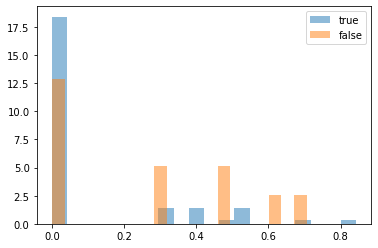

In [139]:
plt.hist(true_std, bins=20, alpha=0.5, label='true', density=True)
plt.hist(true_false, bins=20, alpha=0.5, label='false',density=True)
plt.legend()

Text(0, 0.5, 'std')

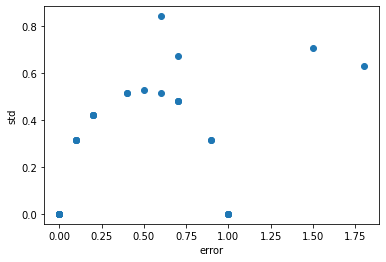

In [140]:
plt.scatter(predictions_augmented['error'], predictions_augmented['predictions']['std'])
plt.xlabel('error')
plt.ylabel('std')

In [141]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

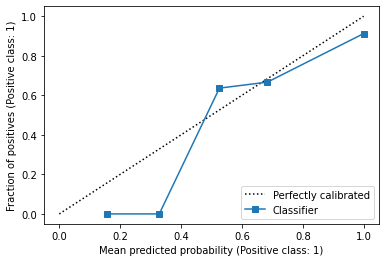

In [144]:
cd = CalibrationDisplay.from_predictions(predictions_augmented['is_correct'], 1-predictions_augmented['predictions']['std'])

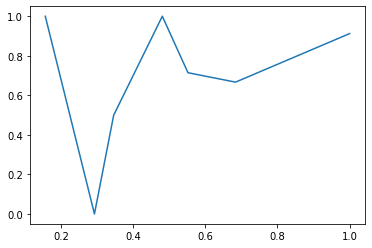

In [131]:
plt.plot(y,x)

In [25]:
predictions_unaugmented = [
    int(extract_prediction(completions, i)) for i in range(len(completions_unaugmented["choices"]))
]
true_unaugmented = [int(e.split("@")[0]) for e in test_prompts_unaugmented["completion"]]


In [26]:
cm_unaugmented = ConfusionMatrix(actual_vector=true_unaugmented, predict_vector=predictions_unaugmented)

In [27]:
print(cm_unaugmented)

Predict  0        1        2        3        4        
Actual
0        11       5        10       1        0        

1        11       2        8        2        0        

2        5        6        8        1        0        

3        1        1        2        1        1        

4        1        1        0        0        0        





Overall Statistics : 

95% CI                                                            (0.18218,0.38192)
ACC Macro                                                         0.71282
ARI                                                               0.01064
AUNP                                                              0.49858
AUNU                                                              0.50582
Bangdiwala B                                                      0.11047
Bennett S                                                         0.10256
CBA                                                               0.18373
CSI                          

In [21]:
cm = ConfusionMatrix(true_augmented, predictions_augmented)


In [22]:
print(cm)

Predict   0         1         2         3         4         
Actual
0         237       24        9         0         0         

1         27        148       51        4         0         

2         0         11        176       13        0         

3         0         0         18        42        0         

4         0         0         0         1         19        





Overall Statistics : 

95% CI                                                            (0.76923,0.82564)
ACC Macro                                                         0.91897
ARI                                                               0.55122
AUNP                                                              0.86197
AUNU                                                              0.87752
Bangdiwala B                                                      0.66116
Bennett S                                                         0.74679
CBA                                                               0

## Train the regression test

In [8]:
train_prompts_augmented = create_single_property_forward_prompts(
    train_data,
    "E isomer pi-pi* wavelength in nm",
    {"E isomer pi-pi* wavelength in nm": "transition wavelength"},
    representation_col="SMILES",
    smiles_augmentation=True,
    encode_value=False,
)
train_prompts_unaugmented = create_single_property_forward_prompts(
    train_data,
    "E isomer pi-pi* wavelength in nm",
    {"E isomer pi-pi* wavelength in nm": "transition wavelength"},
    representation_col="SMILES",
    smiles_augmentation=False,
    encode_value=False,
)


test_prompts_augmented = create_single_property_forward_prompts(
    test_data,
    "E isomer pi-pi* wavelength in nm",
    {"E isomer pi-pi* wavelength in nm": "transition wavelength"},
    representation_col="SMILES",
    smiles_augmentation=True,
    encode_value=False,
)

test_prompts_unaugmented = create_single_property_forward_prompts(
    test_data,
    "E isomer pi-pi* wavelength in nm",
    {"E isomer pi-pi* wavelength in nm": "transition wavelength"},
    representation_col="SMILES",
    smiles_augmentation=False,
    encode_value=False,
)


In [10]:
filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename_augmented = (
    f"run_files/{filename_base}_train_prompts_photoswitch_regression_augemented.jsonl"
)
valid_filename_augmented = (
    f"run_files/{filename_base}_valid_prompts_photoswitch_regression_augmented.jsonl"
)

train_filename= (
    f"run_files/{filename_base}_train_prompts_photoswitch_regression.jsonl"
)
valid_filename = (
    f"run_files/{filename_base}_valid_prompts_photoswitch_regression.jsonl"
)


train_prompts_unaugmented.to_json(train_filename, orient="records", lines=True)
test_prompts_unaugmented.to_json(valid_filename, orient="records", lines=True)

train_prompts_augmented.to_json(train_filename_augmented, orient="records", lines=True)
test_prompts_augmented.to_json(valid_filename_augmented, orient="records", lines=True)

In [11]:
unaugmented_model = fine_tune(train_filename, valid_filename, "ada")

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [12]:
augmented_model = fine_tune(train_filename_augmented, valid_filename, "ada")

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [13]:
augmented_model

'ada:ft-lsmoepfl-2022-09-06-15-52-28'

In [14]:
unaugmented_results = query_gpt3(unaugmented_model, test_prompts_unaugmented)

In [16]:
augmented_results = query_gpt3(augmented_model, test_prompts_augmented)

In [18]:
predictions_unaugmented = [extract_regression_prediction(unaugmented_results, i) for i in range(len(unaugmented_results["choices"]))]

In [26]:
predictions_augmented = [extract_regression_prediction(augmented_results, i) for i in range(len(augmented_results["choices"]))]

{'choices': [<OpenAIObject at 0x29a5772c0> JSON: {
    "finish_reason": "length",
    "index": 0,
    "logprobs": null,
    "text": " 350.0@@@@@@N="
  },
  <OpenAIObject at 0x2989ed130> JSON: {
    "finish_reason": "length",
    "index": 1,
    "logprobs": null,
    "text": " 518.0@@@@@@@@@"
  },
  <OpenAIObject at 0x29a6b1900> JSON: {
    "finish_reason": "length",
    "index": 2,
    "logprobs": null,
    "text": " 515.0@@@0.0@@"
  },
  <OpenAIObject at 0x29a6b1c20> JSON: {
    "finish_reason": "length",
    "index": 3,
    "logprobs": null,
    "text": " 346.0@@@@@@@@@@"
  },
  <OpenAIObject at 0x29a6b1cc0> JSON: {
    "finish_reason": "length",
    "index": 4,
    "logprobs": null,
    "text": " 316.0@@@0.0@@@"
  },
  <OpenAIObject at 0x29a6b1d60> JSON: {
    "finish_reason": "length",
    "index": 5,
    "logprobs": null,
    "text": " 555.0@@@@@@@@@@"
  },
  <OpenAIObject at 0x29a6b1e00> JSON: {
    "finish_reason": "length",
    "index": 6,
    "logprobs": null,
    "text": " 51

In [34]:
df_predictions_augmented = pd.DataFrame({
    'true': test_prompts_augmented['completion'].apply(lambda x: float(x.split('@')[0])),
    'predictions': predictions_augmented,
    'smiles': test_prompts_augmented['repr']
})


df_predictions_unaugmented = pd.DataFrame({
    'true': test_prompts_unaugmented['completion'].apply(lambda x: float(x.split('@')[0])),
    'predictions': predictions_unaugmented,
    'smiles': test_prompts_unaugmented['repr']
})

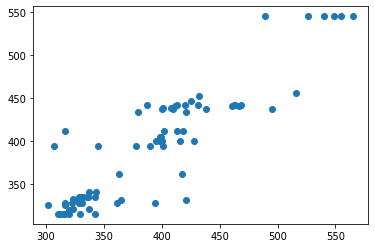

In [35]:
plt.scatter(df_predictions_unaugmented['true'], df_predictions_unaugmented['predictions'])

In [36]:
df_predictions_augmented_agg = df_predictions_augmented.groupby('smiles').agg(['mean', 'std'])

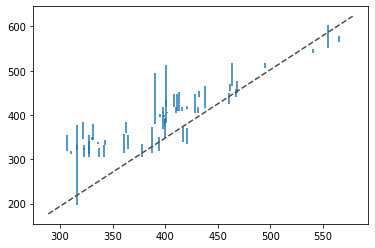

In [39]:
plt.errorbar(
    df_predictions_augmented_agg['true']['mean'],
    df_predictions_augmented_agg['predictions']['mean'],
    yerr=df_predictions_augmented_agg['predictions']['std'],
    linestyle='None',
)

# now plot a dashed diagonal line from lower left to upper right
# getting the limits of the current axes
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# now plot both limits against eachother
ax.plot(xlim, ylim, ls="--", c=".3")


Now, let's try it with more augmentation rounds.

In [40]:
train_prompts_very_augmented = create_single_property_forward_prompts(
    train_data,
    "E isomer pi-pi* wavelength in nm",
    {"E isomer pi-pi* wavelength in nm": "transition wavelength"},
    representation_col="SMILES",
    smiles_augmentation=True,
    encode_value=False,
    smiles_augmentation_rounds=50
)

test_prompts_very_augmented = create_single_property_forward_prompts(
    test_data,
    "E isomer pi-pi* wavelength in nm",
    {"E isomer pi-pi* wavelength in nm": "transition wavelength"},
    representation_col="SMILES",
    smiles_augmentation=True,
    encode_value=False,
        smiles_augmentation_rounds=50
)


In [41]:
filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename_very_augmented = (
    f"run_files/{filename_base}_train_prompts_photoswitch_regression_very_augemented.jsonl"
)
valid_filename_very_augmented = (
    f"run_files/{filename_base}_valid_prompts_photoswitch_regression_augmented.jsonl"
)

train_prompts_very_augmented.to_json(train_filename_very_augmented, orient="records", lines=True)
test_prompts_very_augmented.to_json(valid_filename_very_augmented, orient="records", lines=True)

In [42]:
fine_tune(train_filename_very_augmented, valid_filename_very_augmented, "ada")

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

'ada:ft-lsmoepfl-2022-09-08-15-33-40'

In [43]:
very_augmented_results = query_gpt3("ada:ft-lsmoepfl-2022-09-08-15-33-40", test_prompts_very_augmented)

In [45]:
true_very_augmented = test_prompts_very_augmented['completion'].apply(lambda x: float(x.split('@')[0]))

In [46]:
very_augmented_results_df = pd.DataFrame({
    'true': true_very_augmented,
    'predictions': [extract_regression_prediction(very_augmented_results, i) for i in range(len(very_augmented_results["choices"]))],
    'smiles': test_prompts_very_augmented['repr']
})

In [47]:
very_augmented_results_df_agg = very_augmented_results_df.groupby('smiles').agg(['mean', 'std'])

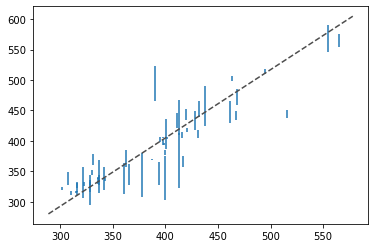

In [49]:
plt.errorbar(very_augmented_results_df_agg['true']['mean'], very_augmented_results_df_agg['predictions']['mean'], yerr=very_augmented_results_df_agg['predictions']['std'], linestyle='None')

# now plot a dashed diagonal line from lower left to upper right
# getting the limits of the current axes
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# now plot both limits against eachother
ax.plot(xlim, ylim, ls="--", c=".3")

In [50]:
from sklearn.metrics import r2_score

In [52]:
df_predictions_unaugmented

,true,predictions,smiles
0,390.0,394.0,OC%11=C(N=CC=C%12)C%12=C(/N=N/C%13=CC=C(NC(C)=...
1,337.0,321.0,CC1=NOC(C)=C1/N=N/C2=CC=C(OC)C=C2
2,316.0,325.0,CC1=C(/N=N/C2=CC=CN=C2)C(C)=NO1
3,410.0,437.0,[H]C5=C(N6CCCCC6)C=CC(/N=N/C7=CC=C(N8CCCCC8)C(...
4,411.0,440.0,Sc1[nH]nc(n1)N=Nc1c([nH]c2c1cccc2)c1ccccc1
...,...,...,...
73,400.0,437.0,OC(C([N+]([O-])=O)=CC([N+]([O-])=O)=C1)=C1/N=N...
74,421.0,434.0,CC(C=C(N(CCC#N)CCO)C=C1)=C1/N=N/C2=CC=C(C(F)(F...
75,361.0,328.0,[H]C%19=CC=C(N=C(N=NC%20=CC=C(OC)C=C%20)S%21)C...
76,461.0,441.0,CC(C=C(N(CCC#N)CCO)C=C1)=C1/N=N/C2=CC=C([N+]([...


In [53]:
r2_score(df_predictions_unaugmented['true'], df_predictions_unaugmented['predictions'])

0.7988700883872927

In [54]:
r2_score(very_augmented_results_df['true'], very_augmented_results_df['predictions'])

0.7924645019207406

In [58]:
r2_score(df_predictions_augmented.dropna()['true'], df_predictions_augmented.dropna()['predictions'])

0.7911510888939333

In [62]:
picp(
    very_augmented_results_df_agg['true']['mean'],
    very_augmented_results_df_agg['predictions']['mean'] -  very_augmented_results_df_agg['predictions']['std'],
    very_augmented_results_df_agg['predictions']['mean'] +  very_augmented_results_df_agg['predictions']['std'],
)


0.2948717948717949

In [63]:
picp(
    very_augmented_results_df_agg['true']['mean'],
    very_augmented_results_df_agg['predictions']['mean'] -  2 * very_augmented_results_df_agg['predictions']['std'],
    very_augmented_results_df_agg['predictions']['mean'] +  2 * very_augmented_results_df_agg['predictions']['std'],
)


0.46153846153846156